# Prepare the data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re 
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold


In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
# Original data
df1 = pd.read_csv('summer-products-with-rating-and-performance_2020-08.csv',encoding='utf-8')
df2 = pd.read_csv('unique-categories.csv',encoding='utf-8')
df3 = pd.read_csv('unique-categories.sorted-by-count.csv',encoding='utf-8')

In [ ]:
listings = df1.copy()

# Preprocessing

### 1. Remove the duplicated values

In [ ]:
print('duplicated values:', listings.duplicated().sum())
listings.drop_duplicates(inplace=True)

duplicated values: 34


### 2. Remove some useless columns

In [ ]:
# the columns with only 1 unique value are deleted
listings.drop(labels=['currency_buyer','theme','crawl_month'],axis=1, inplace=True)
# the colums based on urls are deleted
listings.drop(labels=['product_url','merchant_profile_picture','product_picture'],axis=1, inplace=True)
# the columns based on id numbers/names are deleted
listings.drop(labels=['merchant_title','merchant_id','product_id'],axis=1, inplace=True)
# the column which is not shown to public is deleted
listings.drop(labels=['merchant_name'],axis=1, inplace=True)
# the colunm which has duplicated information with other columns is deleted
listings.drop(labels=['merchant_info_subtitle','title','title_orig'],axis=1, inplace=True)

### 3. Remove the missing values

In [ ]:
listings.isnull().sum()

price                              0
retail_price                       0
units_sold                         0
uses_ad_boosts                     0
rating                             0
rating_count                       0
rating_five_count                 43
rating_four_count                 43
rating_three_count                43
rating_two_count                  43
rating_one_count                  43
badges_count                       0
badge_local_product                0
badge_product_quality              0
badge_fast_shipping                0
tags                               0
product_color                     41
product_variation_size_id         14
product_variation_inventory        0
shipping_option_name               0
shipping_option_price              0
shipping_is_express                0
countries_shipped_to               0
inventory_total                    0
has_urgency_banner              1071
urgency_text                    1071
origin_country                    16
m

Checking columns Individually

In [ ]:
# has_urgency_banner, urgency_text
listings['has_urgency_banner'].fillna(value=0,inplace=True)
print('Has_urgency_banner:\n',listings['has_urgency_banner'].value_counts())
print(('-')*50)
print('Urgency_text:\n ',listings['urgency_text'].value_counts())

# The feature of 'urgency_text' doesn't distribute evenly, i.e. extremely low variance. So we delete it
listings.drop(labels=['urgency_text'],axis=1, inplace=True)

Has_urgency_banner:
 0.0    1071
1.0     468
Name: has_urgency_banner, dtype: int64
--------------------------------------------------
Urgency_text:
  Quantité limitée !                  467
Réduction sur les achats en gros      1
Name: urgency_text, dtype: int64


Origin_country:
 CN    1484
US      31
VE       4
SG       2
GB       1
AT       1
Name: origin_country, dtype: int64


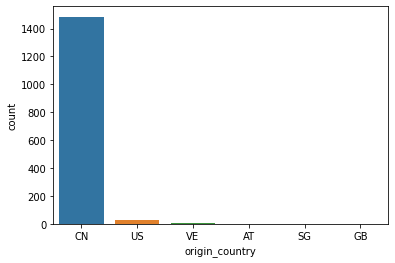

In [ ]:
# origin_country
print('Origin_country:\n', listings['origin_country'].value_counts())
sns.countplot(listings['origin_country'])

# The feature of 'origin_countr' doesn't distribute evenly as well. However, we still want to include this feature
listings['origin_country'] = listings['origin_country'].replace({np.nan:'CN'})

shipping_option_name:
 Livraison standard         1474
Standard Shipping            21
Envio Padrão                  9
Expediere Standard            6
Envío normal                  5
الشحن القياسي                 4
Стандартная доставка          3
Livraison Express             3
Standardversand               3
Standardowa wysyłka           3
Standart Gönderi              2
Spedizione standard           2
การส่งสินค้ามาตรฐาน           2
ការដឹកជញ្ជូនតាមស្តង់ដារ       1
Ekspresowa wysyłka            1
Name: shipping_option_name, dtype: int64


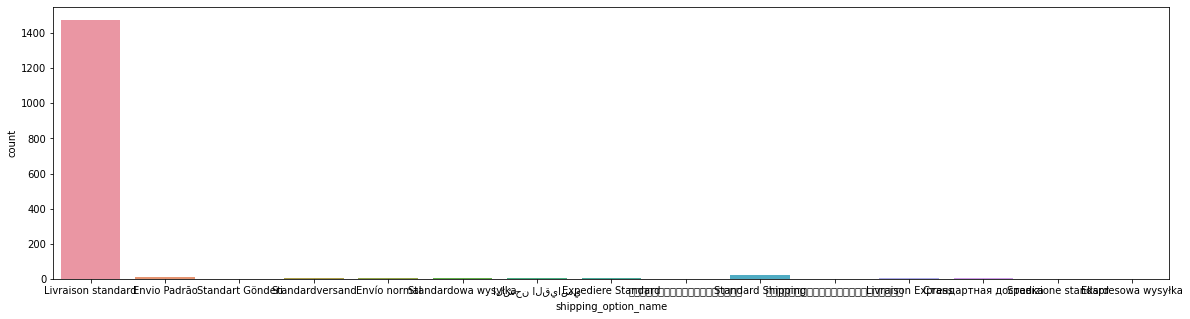

In [ ]:
# shipping_option
print('shipping_option_name:\n', listings['shipping_option_name'].value_counts())
plt.figure(figsize=(20,5))
sns.countplot(listings['shipping_option_name'])

# The feature of 'shipping_option_name' doesn't distribute evenly, i.e. extremely low variance. So we delete it
listings.drop(labels=['shipping_option_name'],axis=1, inplace=True)

In [ ]:
# rating_*_count
listings.dropna(axis=0,inplace=True)

In [ ]:
# product_color
listings['product_color'].replace(np.nan, 'others', inplace=True)

In [ ]:
# product_variation_size_id
listings['product_variation_size_id']=listings['product_variation_size_id'].replace('nan','other')

In [ ]:
listings.isnull().sum()

price                           0
retail_price                    0
units_sold                      0
uses_ad_boosts                  0
rating                          0
rating_count                    0
rating_five_count               0
rating_four_count               0
rating_three_count              0
rating_two_count                0
rating_one_count                0
badges_count                    0
badge_local_product             0
badge_product_quality           0
badge_fast_shipping             0
tags                            0
product_color                   0
product_variation_size_id       0
product_variation_inventory     0
shipping_option_price           0
shipping_is_express             0
countries_shipped_to            0
inventory_total                 0
has_urgency_banner              0
origin_country                  0
merchant_rating_count           0
merchant_rating                 0
merchant_has_profile_picture    0
dtype: int64

In [ ]:
listings.head(3)

,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,tags,product_color,product_variation_size_id,product_variation_inventory,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,origin_country,merchant_rating_count,merchant_rating,merchant_has_profile_picture
0,16.0,14,100,0,3.76,54,26.0,8.0,10.0,1.0,9.0,0,0,0,0,"Summer,Fashion,womenunderwearsuit,printedpajam...",white,M,50,4,0,34,50,1.0,CN,568,4.128521,0
1,8.0,22,20000,1,3.45,6135,2269.0,1027.0,1118.0,644.0,1077.0,0,0,0,0,"Mini,womens dresses,Summer,Patchwork,fashion d...",green,XS,50,2,0,41,50,1.0,CN,17752,3.899673,0
2,8.0,43,100,0,3.57,14,5.0,4.0,2.0,0.0,3.0,0,0,0,0,"Summer,cardigan,women beachwear,chiffon,Sexy w...",leopardprint,XS,1,3,0,36,50,1.0,CN,295,3.989831,0


# Data Description

### Satatistics

In [ ]:
listings.describe()

,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,product_variation_inventory,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,merchant_rating_count,merchant_rating,merchant_has_profile_picture
count,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1.444000e+03,1444.000000,1444.000000
mean,8.364287,23.356648,4413.711219,0.437673,3.782015,901.364958,437.123269,177.335180,131.890582,61.950831,93.065097,0.100416,0.016620,0.072022,0.011773,33.141274,2.347645,0.001385,40.191828,49.847645,0.302632,2.565842e+04,4.028446,0.150970
std,3.900855,30.679590,9147.195371,0.496272,0.474017,1946.923067,962.504611,391.091071,300.165832,143.098955,199.471391,0.325024,0.127889,0.258614,0.107900,21.292687,1.009134,0.037203,19.537016,2.392597,0.459556,7.663189e+04,0.194358,0.358143
min,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,6.000000,1.000000,0.000000,3.000000e+00,2.941176,0.000000
25%,5.840000,7.000000,100.000000,0.000000,3.530000,28.000000,13.000000,5.000000,4.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2.000000,0.000000,31.000000,50.000000,0.000000,2.127000e+03,3.917353,0.000000
50%,8.000000,10.000000,1000.000000,0.000000,3.830000,179.000000,82.000000,32.000000,25.000000,11.000000,21.000000,0.000000,0.000000,0.000000,0.000000,50.000000,2.000000,0.000000,40.000000,50.000000,0.000000,8.357000e+03,4.039485,0.000000
75%,11.000000,26.000000,5000.000000,1.000000,4.082500,890.000000,411.250000,169.250000,131.250000,63.000000,96.000000,0.000000,0.000000,0.000000,0.000000,50.000000,3.000000,0.000000,43.000000,50.000000,1.000000,2.417550e+04,4.155094,0.000000
max,49.000000,252.000000,100000.000000,1.000000,5.000000,20744.000000,11548.000000,4152.000000,3658.000000,2003.000000,2559.000000,2.000000,1.000000,1.000000,1.000000,50.000000,12.000000,1.000000,140.000000,50.000000,1.000000,2.174765e+06,4.577519,1.000000


### Plot some numerical features

Text(0.5, 1.0, 'merchant_rating_count')

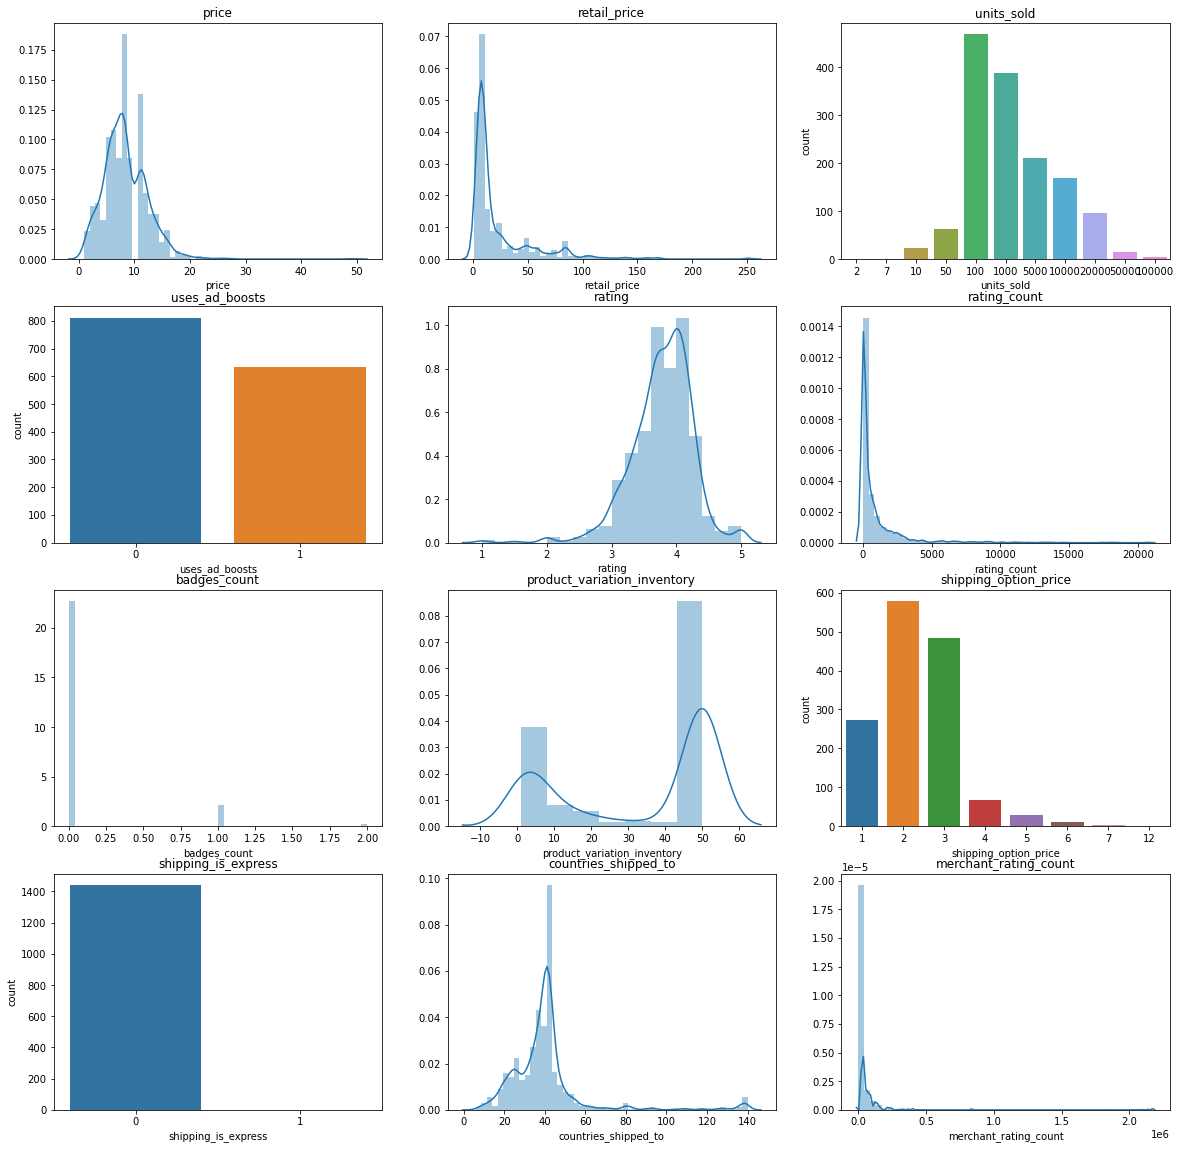

In [ ]:
plt.figure(figsize=(20,20))
# plot 1:
plt.subplot(4, 3, 1)
sns.distplot(listings['price'],bins=50)
plt.title("price")

# plot 2:
plt.subplot(4, 3, 2)
sns.distplot(listings['retail_price'],bins=50)
plt.title("retail_price")
# plot 3:
plt.subplot(4, 3, 3)
sns.countplot(listings['units_sold'])
plt.title("units_sold")
# plot 4:
plt.subplot(4, 3, 4)
sns.countplot(listings['uses_ad_boosts'])
plt.title("uses_ad_boosts")
# plot 5:
plt.subplot(4, 3, 5)
sns.distplot(listings['rating'],bins=20)
plt.title("rating")

# plot 6:
plt.subplot(4, 3, 6)
sns.distplot(listings['rating_count'],bins=50)
plt.title("rating_count")

# plot 7:
plt.subplot(4, 3, 7)
sns.distplot(listings['badges_count'],bins=50)
plt.title("badges_count")


# plot 8:
plt.subplot(4, 3, 8)
sns.distplot(listings['product_variation_inventory'])
plt.title("product_variation_inventory")

# plot 9:
plt.subplot(4, 3, 9)
sns.countplot(listings['shipping_option_price'])
plt.title("shipping_option_price")

# plot 10:
plt.subplot(4, 3, 10)
sns.countplot(listings['shipping_is_express'])
plt.title("shipping_is_express")

# plot 11:
plt.subplot(4, 3, 11)
sns.distplot(listings['countries_shipped_to'])
plt.title("countries_shipped_to")

# plot 12:
plt.subplot(4, 3, 12)
sns.distplot(listings['merchant_rating_count'])
plt.title("merchant_rating_count")

### Plot the correlation

In [ ]:
corr = listings.corr()
corr

,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,product_variation_inventory,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,merchant_rating_count,merchant_rating,merchant_has_profile_picture
price,1.000000,0.304908,-0.025266,-0.077791,0.078231,-0.002555,-0.000094,0.001154,-0.013477,-0.012942,0.002822,0.077368,0.050810,0.034453,0.090255,0.298252,0.878026,0.192305,-0.014754,-0.216215,-0.031097,-0.021846,0.039042,0.018173
retail_price,0.304908,1.000000,0.011112,-0.021502,0.036714,0.046311,0.046007,0.053559,0.039630,0.035323,0.040030,0.035186,0.033990,0.015452,0.028667,0.128799,0.265047,0.001388,0.047838,-0.007322,-0.022800,0.042834,0.073185,0.026127
units_sold,-0.025266,0.011112,1.000000,-0.017386,0.089942,0.904317,0.878693,0.894729,0.901657,0.877106,0.846284,0.042962,-0.013050,0.075310,-0.035622,0.123669,-0.034234,-0.017569,-0.022122,-0.000973,-0.035876,0.245456,0.132394,0.124389
uses_ad_boosts,-0.077791,-0.021502,-0.017386,1.000000,-0.052890,-0.040978,-0.042194,-0.041989,-0.037402,-0.036964,-0.031238,0.036679,0.070928,-0.008197,0.046067,-0.154202,-0.064639,-0.032856,-0.023032,0.034603,0.011355,0.040472,-0.032051,0.006189
rating,0.078231,0.036714,0.089942,-0.052890,1.000000,0.106805,0.151975,0.114718,0.061286,0.018239,-0.021090,0.233709,0.006763,0.298882,-0.020382,0.058312,0.079910,-0.004088,0.039593,-0.039697,-0.037000,0.052462,0.273429,0.036987
rating_count,-0.002555,0.046311,0.904317,-0.040978,0.106805,1.000000,0.983592,0.996023,0.980599,0.944185,0.908509,0.066802,-0.013840,0.095904,-0.012230,0.123158,-0.013914,-0.017056,-0.012007,0.002147,-0.026906,0.234371,0.155819,0.140399
rating_five_count,-0.000094,0.046007,0.878693,-0.042194,0.151975,0.983592,1.000000,0.980628,0.931424,0.871627,0.825417,0.113322,-0.010978,0.153071,-0.012512,0.115587,-0.009126,-0.016745,-0.012084,-0.007305,-0.029675,0.227955,0.177760,0.143886
rating_four_count,0.001154,0.053559,0.894729,-0.041989,0.114718,0.996023,0.980628,1.000000,0.975952,0.932640,0.891474,0.063761,-0.015934,0.092322,-0.010325,0.124838,-0.010619,-0.016750,-0.011004,0.008282,-0.026206,0.229530,0.157674,0.138677
rating_three_count,-0.013477,0.039630,0.901657,-0.037402,0.061286,0.980599,0.931424,0.975952,1.000000,0.984858,0.951852,0.015449,-0.017951,0.033695,-0.012948,0.124894,-0.025905,-0.016369,-0.007621,0.011851,-0.022332,0.237247,0.124204,0.124137
rating_two_count,-0.012942,0.035323,0.877106,-0.036964,0.018239,0.944185,0.871627,0.932640,0.984858,1.000000,0.981815,-0.015807,-0.017829,-0.006046,-0.011991,0.123600,-0.027192,-0.015868,-0.010131,0.014130,-0.019048,0.230001,0.103836,0.119869


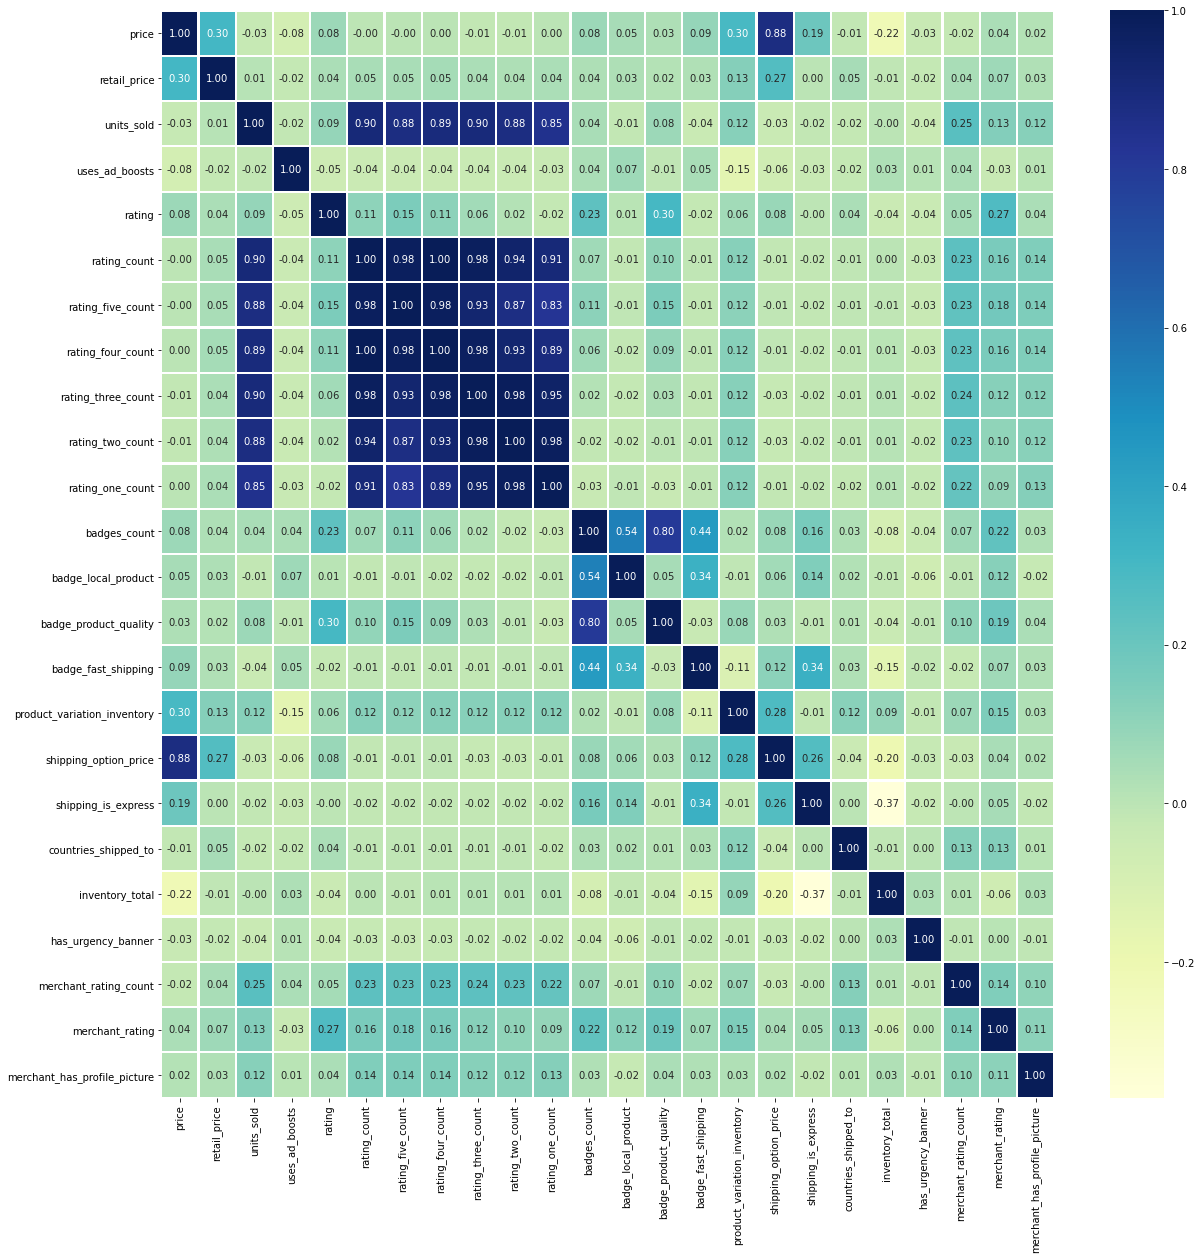

In [ ]:
fig,ax = plt.subplots(figsize = (20,20))
ax = sns.heatmap(corr,
                 annot=True,
                 linewidths=1.2,
                 fmt=".2f",
                 cmap="YlGnBu");

Text(0.5, 1.0, 'Features Correlating with units_sold')

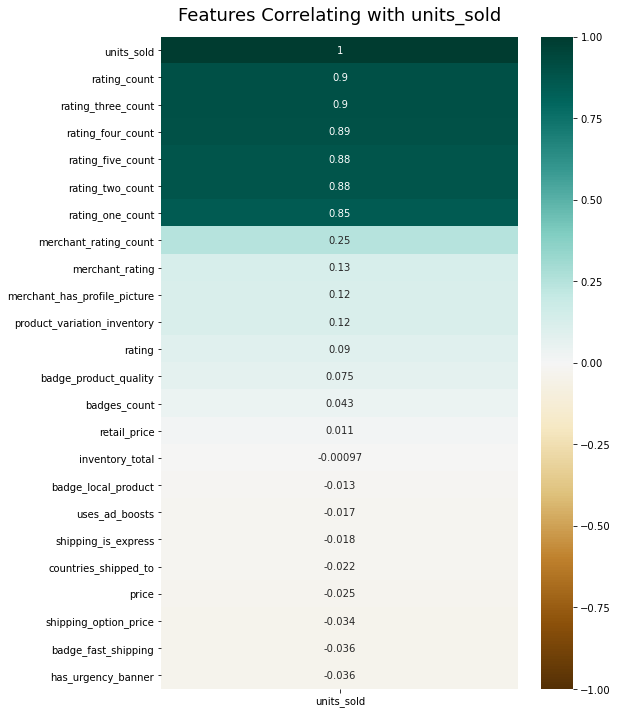

In [ ]:
target_col='units_sold'
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(listings.corr()[[target_col]].sort_values(by=target_col, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title(f'Features Correlating with {target_col}', fontdict={'fontsize':18}, pad=16)

### Plot some categorical features

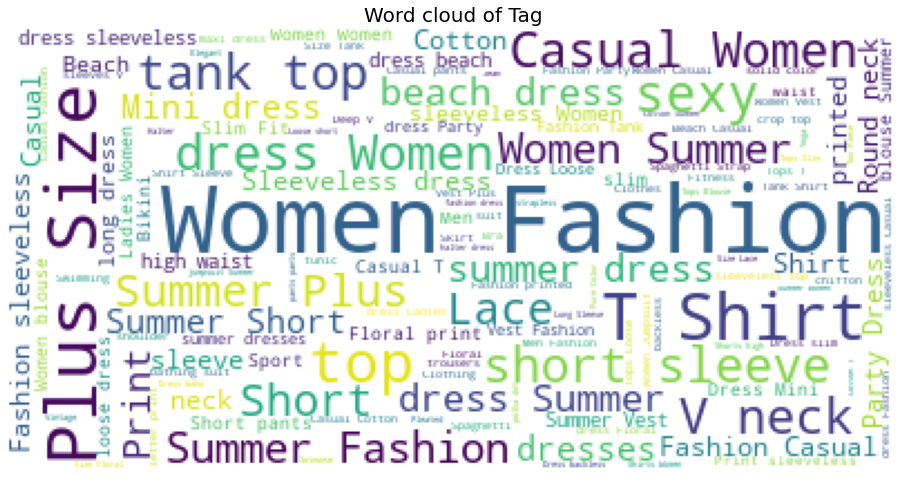

In [ ]:
# Plot some categorical features 
word = " ".join(listings['tags'].str.split(',').sum())

fig = plt.gcf()
fig.set_size_inches( 16, 10)
wordcloud = WordCloud(background_color='white').generate(word) 
plt.imshow(wordcloud)
plt.title('Word cloud of Tag',{'fontsize':20})
plt.axis('off')
plt.show()

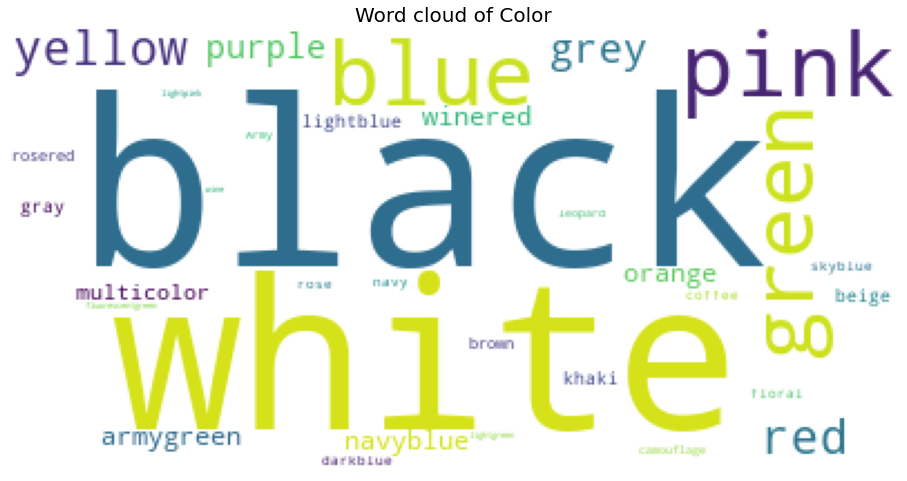

In [ ]:
# Plot some categorical features 
word = " ".join(listings['product_color'])

fig = plt.gcf()
fig.set_size_inches( 16, 10)
wordcloud = WordCloud(background_color='white').generate(word) 
plt.imshow(wordcloud)
plt.title('Word cloud of Color',{'fontsize':20})
plt.axis('off')
plt.show()

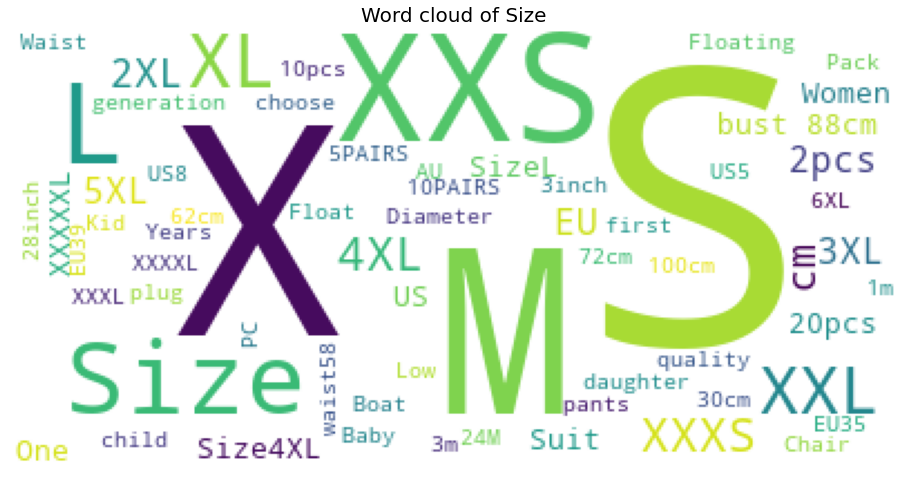

In [ ]:
# Plot some categorical features 
word = " ".join(listings['product_variation_size_id'])

fig = plt.gcf()
fig.set_size_inches( 16, 10)
wordcloud = WordCloud(background_color='white').generate(word) 
plt.imshow(wordcloud)
plt.title('Word cloud of Size',{'fontsize':20})
plt.axis('off')
plt.show()

# Feature engineering

After knowing the characteristics of these features, we can conduct feature engineering

### Feature extraction on the existing features

In [ ]:
# keywords of tag
bag_of_words = df3['keyword'].head(20).str.lower().tolist()
for word in bag_of_words:
    listings["tag_"+ word] = listings.tags.str.lower().str.contains(word).astype(int)

listings['tag_count']=listings['tags'].str.split(',').str.len()
listings.drop(['tags'],axis=1,inplace=True)

In [ ]:
# Product color
change_to_colour = {
    'navyblue': 'blue', 'lightblue': 'blue', 'skyblue': 'blue', 'lakeblue': 'blue', 'darkblue': 'blue', 'denimblue': 'blue', 'navy blue': 'blue', 'prussianblue': 'blue',
    'navy': 'blue',
    'armygreen': 'green', 'army green': 'green', 'fluorescentgreen': 'green', 'mintgreen': 'green', 'light green': 'green', 'lightgreen': 'green',
    'applegreen': 'green', 'darkgreen': 'green', 'army': 'green', 'khaki': 'green', 'lightkhaki': 'green',
    'lightyellow': 'yellow', 
    'winered': 'red', 'wine red': 'red', 'lightred': 'red', 'coralred': 'red', 'rose red': 'red', 'watermelonred': 'red', 'orange-red': 'red', 'rosered': 'red',
    'claret': 'red', 'burgundy': 'red', 
    'gray': 'grey', 'silver': 'grey','lightgray': 'grey', 'lightgrey': 'grey', 'greysnakeskinprint': 'grey',
    'coffee': 'brown', 'camel': 'brown', 'tan': 'brown', 
    'offwhite': 'white', 'ivory': 'white', 'nude': 'white',
    'lightpink': 'pink', 'dustypink':'pink', 'rosegold': 'pink',
    'lightpurple': 'purple', 'coolblack': 'black', 'apricot': 'orange', 'offblack': 'black'
}

def update_color(context):
    if change_to_colour.get(context, False):
        return change_to_colour.get(context)
    elif '&' in context:
        return 'dual'
    elif context in change_to_colour.values():
        return context
    else:
        return 'others'
    
listings['product_color']=listings['product_color'].str.lower()
listings['product_color'] = listings['product_color'].apply(update_color)

In [ ]:
# product_variation_size_id
listings['product_variation_size_id']=listings['product_variation_size_id'].astype(str)
listings['product_variation_size_id']=listings['product_variation_size_id'].str.lower().str.replace('size','').str.replace('.','').str.replace('size-','').str.replace('size--','').str.replace('-','').str.replace('--','').str.replace('x   l','verybig')
list_weird=[ 'eu 35',  '5','35', '34', '2', 'women  37', '36', '5''eu 35', '4','women  36', '29', 'one ', '1', '33','100 x 100cm(393 x 393inch)','32/l','1m by 3m','1pc','1 pc','100 cm','30 cm','100 x 100cm(39.3 x 39.3inch)','white', '25', 'round', 'pack of 1', '1 pc.','au plug low quality', 'daughter 24m',  'baby float boat','10 ml', '60', '-l', '17', 'women  ','3 layered anklet','80 x 200 cm','floating chair for kid', 'b','h01', '40 cm']

def change_size(context):
    if 'xl' in context:
        return 'verybig'
    elif 'xs' in context:
        return 'verysmall'
    elif 's' in context:
        return 's'
    elif context in list_weird:
        return 'other'
    else:
        return context
    
listings['product_variation_size_id']=listings['product_variation_size_id'].apply(change_size)

### Create new features

In [ ]:
# positive value means the product is more expensive, negative value means cheaper
listings['price_diff'] = listings['price'] - listings['retail_price']

# product ratings
listings['positive_rating'] = listings['rating_five_count'] / listings['rating_count']
listings['negative_rating'] = listings['rating_one_count'] / listings['rating_count']

# full variation inventory
listings['full_variation_inventory'] = listings['product_variation_inventory'].map(lambda x : 1 if x==50 else 0)
listings['full_inventory'] = listings['inventory_total'].map(lambda x : 1 if x==50 else 0)

# drop the express column, since it is in low variance
listings.drop(labels=['shipping_is_express'],axis=1, inplace=True)

In [ ]:
# OneHotEncoder the category features
category_feature=['product_color', 'product_variation_size_id','uses_ad_boosts','badge_local_product','badge_product_quality','badge_fast_shipping',\
                 'has_urgency_banner','origin_country','merchant_has_profile_picture','full_variation_inventory',\
                 'full_inventory','tag_summer','tag_women\'s fashion','tag_fashion','tag_women','tag_casual',\
                 'tag_plus size','tag_sleeveless','tag_dress','tag_shorts','tag_tops','tag_sexy','tag_beach',\
                 'tag_sleeve','tag_short sleeves','tag_print','tag_shirt','tag_tank','tag_necks','tag_v-neck','tag_printed']

for f in category_feature:
    temp = pd.get_dummies(listings[f],prefix = f)
    listings = pd.concat([listings,temp],axis=1)
    listings.drop(labels=f,axis=1, inplace=True)

In [ ]:
listings.head()

,price,retail_price,units_sold,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,product_variation_inventory,shipping_option_price,countries_shipped_to,inventory_total,merchant_rating_count,merchant_rating,tag_count,price_diff,positive_rating,negative_rating,product_color_black,product_color_blue,product_color_brown,product_color_dual,product_color_green,product_color_grey,product_color_orange,product_color_others,product_color_pink,product_color_purple,product_color_red,product_color_white,product_color_yellow,product_variation_size_id_ m,product_variation_size_id_l,product_variation_size_id_m,product_variation_size_id_other,product_variation_size_id_s,product_variation_size_id_verybig,product_variation_size_id_verysmall,uses_ad_boosts_0,uses_ad_boosts_1,badge_local_product_0,badge_local_product_1,badge_product_quality_0,badge_product_quality_1,badge_fast_shipping_0,badge_fast_shipping_1,has_urgency_banner_0.0,has_urgency_banner_1.0,origin_country_CN,origin_country_GB,origin_country_SG,origin_country_US,origin_country_VE,merchant_has_profile_picture_0,merchant_has_profile_picture_1,full_variation_inventory_0,full_variation_inventory_1,full_inventory_0,full_inventory_1,tag_summer_0,tag_summer_1,tag_women's fashion_0,tag_women's fashion_1,tag_fashion_0,tag_fashion_1,tag_women_0,tag_women_1,tag_casual_0,tag_casual_1,tag_plus size_0,tag_plus size_1,tag_sleeveless_0,tag_sleeveless_1,tag_dress_0,tag_dress_1,tag_shorts_0,tag_shorts_1,tag_tops_0,tag_tops_1,tag_sexy_0,tag_sexy_1,tag_beach_0,tag_beach_1,tag_sleeve_0,tag_sleeve_1,tag_short sleeves_0,tag_short sleeves_1,tag_print_0,tag_print_1,tag_shirt_0,tag_shirt_1,tag_tank_0,tag_tank_1,tag_necks_0,tag_necks_1,tag_v-neck_0,tag_v-neck_1,tag_printed_0,tag_printed_1
0,16.00,14,100,3.76,54,26.0,8.0,10.0,1.0,9.0,0,50,4,34,50,568,4.128521,24,2.00,0.481481,0.166667,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1
1,8.00,22,20000,3.45,6135,2269.0,1027.0,1118.0,644.0,1077.0,0,50,2,41,50,17752,3.899673,15,-14.00,0.369845,0.175550,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,1,0,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0
2,8.00,43,100,3.57,14,5.0,4.0,2.0,0.0,3.0,0,1,3,36,50,295,3.989831,19,-35.00,0.357143,0.214286,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,0,1
3,8.00,8,5000,4.03,579,295.0,119.0,87.0,42.0,36.0,0,50,2,41,50,23832,4.020435,18,0.00,0.509499,0.062176,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1
4,2.72,3,100,3.10,20,6.0,4.0,2.0,2.0,6.0,0,1,1,35,50,14482,4.001588,13,-0.28,0.300000,0.300000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0


In [ ]:
listings.shape

(1444, 102)

In [ ]:
listings.to_csv('listings2.csv')

In [ ]:
listings=pd.read_csv('listings2.csv',encoding='utf-8')

# Feature selection
Now we have 102 features in total, we want to choose the significant ones to make the model fast and accurate

In [ ]:
train_X = listings.drop(labels=['units_sold'],axis=1)
train_y = listings['units_sold']

In [ ]:
# The performance of the feature set before selection -81 dimensions
cross_val_score(RFC(n_estimators=100,random_state=0),train_X,train_y,cv=5).mean()

0.7756175509419454

1. Variance filter: Let's first filter the features with low variance (i.e. p=0.9)

In [ ]:
# we reduced the dimension to 67
variance_filter = VarianceThreshold(threshold=0.9*0.1)
x_var = variance_filter.fit_transform(train_X)

x_var = pd.DataFrame(x_var)
x_var.shape

(1444, 67)

In [ ]:
# The performance of the feature set after variance filter
# we have slight improvement by 0.006
cross_val_score(RFC(n_estimators=100,random_state=0),x_var,train_y,cv=5).mean()

0.7811562860438293

In [ ]:
feature_name = train_X.columns[variance_filter.get_support(indices=False)]
x_var.columns= feature_name
x_var

,price,retail_price,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,product_variation_inventory,shipping_option_price,countries_shipped_to,inventory_total,merchant_rating_count,tag_count,price_diff,product_color_black,product_color_blue,product_color_white,product_variation_size_id_m,product_variation_size_id_s,product_variation_size_id_verysmall,uses_ad_boosts_0,uses_ad_boosts_1,has_urgency_banner_0.0,has_urgency_banner_1.0,merchant_has_profile_picture_0,merchant_has_profile_picture_1,full_variation_inventory_0,full_variation_inventory_1,tag_summer_0,tag_summer_1,tag_women's fashion_0,tag_women's fashion_1,tag_casual_0,tag_casual_1,tag_plus size_0,tag_plus size_1,tag_sleeveless_0,tag_sleeveless_1,tag_dress_0,tag_dress_1,tag_shorts_0,tag_shorts_1,tag_tops_0,tag_tops_1,tag_sexy_0,tag_sexy_1,tag_beach_0,tag_beach_1,tag_sleeve_0,tag_sleeve_1,tag_short sleeves_0,tag_short sleeves_1,tag_print_0,tag_print_1,tag_shirt_0,tag_shirt_1,tag_tank_0,tag_tank_1,tag_necks_0,tag_necks_1,tag_v-neck_0,tag_v-neck_1,tag_printed_0,tag_printed_1
0,16.00,14.0,3.76,54.0,26.0,8.0,10.0,1.0,9.0,0.0,50.0,4.0,34.0,50.0,568.0,24.0,2.00,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,8.00,22.0,3.45,6135.0,2269.0,1027.0,1118.0,644.0,1077.0,0.0,50.0,2.0,41.0,50.0,17752.0,15.0,-14.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,8.00,43.0,3.57,14.0,5.0,4.0,2.0,0.0,3.0,0.0,1.0,3.0,36.0,50.0,295.0,19.0,-35.00,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,8.00,8.0,4.03,579.0,295.0,119.0,87.0,42.0,36.0,0.0,50.0,2.0,41.0,50.0,23832.0,18.0,0.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,2.72,3.0,3.10,20.0,6.0,4.0,2.0,2.0,6.0,0.0,1.0,1.0,35.0,50.0,14482.0,13.0,-0.28,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,6.00,9.0,4.08,1367.0,722.0,293.0,185.0,77.0,90.0,0.0,50.0,2.0,41.0,50.0,5316.0,24.0,-3.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1440,2.00,56.0,3.07,28.0,11.0,3.0,1.0,3.0,10.0,0.0,2.0,1.0,26.0,50.0,4435.0,18.0,-54.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1441,5.00,19.0,3.71,59.0,24.0,15.0,8.0,3.0,9.0,0.0,15.0,2.0,11.0,50.0,210.0,12.0,-14.00,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1442,13.00,11.0,2.50,2.0,0.0,1.0,0.0,0.0,1.0,0.0,36.0,3.0,29.0,50.0,31.0,21.0,2.00,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


2. Feature importance: put the features into the RF model and get the feature importance individually, we choose the feature with more importance

In [ ]:
# find the optimal threshold of the feature importance

RFC_=RFC(n_estimators=100, random_state=0) 
max_importance=(RFC_.fit(train_X,train_y).feature_importances_).max()
max_importance

0.13359807696377354

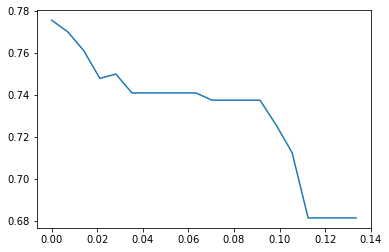

In [ ]:
threshold_range=np.linspace(0,max_importance,20)
score=[]
for i in threshold_range:
    x_embeded=SelectFromModel(RFC_, threshold=i).fit_transform(train_X,train_y)
    perform=cross_val_score(RFC_,x_embeded,train_y,cv=5).mean()
    score.append(perform)
plt.plot(threshold_range,score)
plt.show()

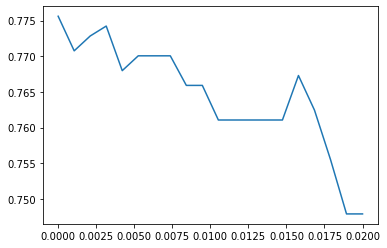

In [ ]:
#narrow the range of threshold
threshold_range=np.linspace(0.00,0.02,20)
score=[]
for i in threshold_range:
    x_embeded=SelectFromModel(RFC_, threshold=i).fit_transform(train_X,train_y)
    perform=cross_val_score(RFC_,x_embeded,train_y,cv=5).mean()
    score.append(perform)
plt.plot(threshold_range,score)
plt.show()

In [ ]:
# we regard 0.0025 as the optimal threshold
# we reduced the dimension to 59
RFC_=RFC(n_estimators=100, random_state=0) 
embed_filter = SelectFromModel(RFC_,threshold=0.0025)
X_embed=embed_filter.fit_transform(train_X,train_y)
print(X_embed.shape)
X_embed = pd.DataFrame(X_embed)

(1444, 59)


In [ ]:
# the performance decreased by 0.009
cross_val_score(RFC(n_estimators=100,random_state=0),X_embed,train_y,cv=5).mean()

0.7666186082276047

In [ ]:
feature_name_embed = train_X.columns[embed_filter.get_support()]
X_embed.columns = feature_name_embed
X_embed

,price,retail_price,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,product_variation_inventory,shipping_option_price,countries_shipped_to,merchant_rating_count,merchant_rating,tag_count,price_diff,positive_rating,negative_rating,product_color_black,product_color_green,product_color_white,product_variation_size_id_s,product_variation_size_id_verysmall,uses_ad_boosts_0,uses_ad_boosts_1,merchant_has_profile_picture_0,merchant_has_profile_picture_1,full_variation_inventory_0,full_variation_inventory_1,tag_summer_0,tag_summer_1,tag_casual_0,tag_casual_1,tag_plus size_0,tag_plus size_1,tag_sleeveless_0,tag_sleeveless_1,tag_dress_0,tag_dress_1,tag_shorts_0,tag_shorts_1,tag_tops_0,tag_tops_1,tag_sexy_0,tag_sexy_1,tag_beach_0,tag_beach_1,tag_sleeve_0,tag_sleeve_1,tag_short sleeves_1,tag_print_0,tag_print_1,tag_shirt_0,tag_shirt_1,tag_tank_0,tag_tank_1,tag_necks_0,tag_printed_0,tag_printed_1
0,16.00,14.0,3.76,54.0,26.0,8.0,10.0,1.0,9.0,50.0,4.0,34.0,568.0,4.128521,24.0,2.00,0.481481,0.166667,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
1,8.00,22.0,3.45,6135.0,2269.0,1027.0,1118.0,644.0,1077.0,50.0,2.0,41.0,17752.0,3.899673,15.0,-14.00,0.369845,0.175550,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,8.00,43.0,3.57,14.0,5.0,4.0,2.0,0.0,3.0,1.0,3.0,36.0,295.0,3.989831,19.0,-35.00,0.357143,0.214286,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,8.00,8.0,4.03,579.0,295.0,119.0,87.0,42.0,36.0,50.0,2.0,41.0,23832.0,4.020435,18.0,0.00,0.509499,0.062176,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,2.72,3.0,3.10,20.0,6.0,4.0,2.0,2.0,6.0,1.0,1.0,35.0,14482.0,4.001588,13.0,-0.28,0.300000,0.300000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,6.00,9.0,4.08,1367.0,722.0,293.0,185.0,77.0,90.0,50.0,2.0,41.0,5316.0,4.224605,24.0,-3.00,0.528164,0.065838,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
1440,2.00,56.0,3.07,28.0,11.0,3.0,1.0,3.0,10.0,2.0,1.0,26.0,4435.0,3.696054,18.0,-54.00,0.392857,0.357143,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1441,5.00,19.0,3.71,59.0,24.0,15.0,8.0,3.0,9.0,15.0,2.0,11.0,210.0,3.961905,12.0,-14.00,0.406780,0.152542,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1442,13.00,11.0,2.50,2.0,0.0,1.0,0.0,0.0,1.0,36.0,3.0,29.0,31.0,3.774194,21.0,2.00,0.000000,0.500000,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


# Data for modeling

2 feature sets can be used
- train_X ， 101 dimension, no feature seletion
- x_var, 67 dimension, filter the features whose virance is less than 0.1

### 1. train_X

In [ ]:
# feature set 1
train_y
train_X

,price,retail_price,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,product_variation_inventory,shipping_option_price,countries_shipped_to,inventory_total,merchant_rating_count,merchant_rating,tag_count,price_diff,positive_rating,negative_rating,product_color_black,product_color_blue,product_color_brown,product_color_dual,product_color_green,product_color_grey,product_color_orange,product_color_others,product_color_pink,product_color_purple,product_color_red,product_color_white,product_color_yellow,product_variation_size_id_ m,product_variation_size_id_l,product_variation_size_id_m,product_variation_size_id_other,product_variation_size_id_s,product_variation_size_id_verybig,product_variation_size_id_verysmall,uses_ad_boosts_0,uses_ad_boosts_1,badge_local_product_0,badge_local_product_1,badge_product_quality_0,badge_product_quality_1,badge_fast_shipping_0,badge_fast_shipping_1,has_urgency_banner_0.0,has_urgency_banner_1.0,origin_country_CN,origin_country_GB,origin_country_SG,origin_country_US,origin_country_VE,merchant_has_profile_picture_0,merchant_has_profile_picture_1,full_variation_inventory_0,full_variation_inventory_1,full_inventory_0,full_inventory_1,tag_summer_0,tag_summer_1,tag_women's fashion_0,tag_women's fashion_1,tag_fashion_0,tag_fashion_1,tag_women_0,tag_women_1,tag_casual_0,tag_casual_1,tag_plus size_0,tag_plus size_1,tag_sleeveless_0,tag_sleeveless_1,tag_dress_0,tag_dress_1,tag_shorts_0,tag_shorts_1,tag_tops_0,tag_tops_1,tag_sexy_0,tag_sexy_1,tag_beach_0,tag_beach_1,tag_sleeve_0,tag_sleeve_1,tag_short sleeves_0,tag_short sleeves_1,tag_print_0,tag_print_1,tag_shirt_0,tag_shirt_1,tag_tank_0,tag_tank_1,tag_necks_0,tag_necks_1,tag_v-neck_0,tag_v-neck_1,tag_printed_0,tag_printed_1
0,16.00,14,3.76,54,26.0,8.0,10.0,1.0,9.0,0,50,4,34,50,568,4.128521,24,2.00,0.481481,0.166667,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1
1,8.00,22,3.45,6135,2269.0,1027.0,1118.0,644.0,1077.0,0,50,2,41,50,17752,3.899673,15,-14.00,0.369845,0.175550,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,1,0,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0
2,8.00,43,3.57,14,5.0,4.0,2.0,0.0,3.0,0,1,3,36,50,295,3.989831,19,-35.00,0.357143,0.214286,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,0,1
3,8.00,8,4.03,579,295.0,119.0,87.0,42.0,36.0,0,50,2,41,50,23832,4.020435,18,0.00,0.509499,0.062176,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1
4,2.72,3,3.10,20,6.0,4.0,2.0,2.0,6.0,0,1,1,35,50,14482,4.001588,13,-0.28,0.300000,0.300000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,6.00,9,4.08,1367,722.0,293.0,185.0,77.0,90.0,0,50,2,41,50,5316,4.224605,24,-3.00,0.528164,0.065838,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1
1569,2.00,56,3.07,28,11.0,3.0,1.0,3.0,10.0,0,2,1,26,50,4435,3.696054,18,-54.00,0.392857,0.357143,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,

Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_X,train_y, test_size=0.2,random_state=0)

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {
     'learning_rate': [0.01, 0.05, 0.1, 0.5], 
     'n_estimators': np.arange(100,250,10)
 }
 #'learning_rate': [0.01, 0.05, 0.1, 0.5, 1], 'n_estimators': np.arange(100,200,10),
grid_cv = GridSearchCV(ada, param_grid= params, cv=5, n_jobs=-1)
grid_cv.fit(x_train,y_train) #To remove
grid_cv.best_params_ #To remove
print('The best parameters values are ', grid_cv.best_params_) 

In [ ]:
clf = DecisionTreeClassifier(max_depth=8)#,min_samples_split=150,min_samples_leaf=80

ada = AdaBoostClassifier(clf, n_estimators=160, learning_rate=0.5)#230
ada.fit(x_train,y_train)#To remove

predict_results_train=ada.predict(x_train)
print('Accuracy of train set: ',accuracy_score(predict_results_train, y_train))
predict_results=ada.predict(x_test)
print('Accuracy of test set: ',accuracy_score(predict_results, y_test))
#print(cross_val_score(ada,x_train,y_train,cv=5).mean())

Accuracy of train set:  1.0
Accuracy of test set:  0.7626728110599078


最大得分：0.7643564356435644 子树数量为：61


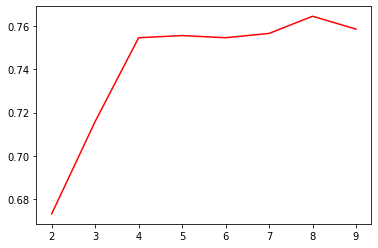

In [ ]:
score_lt = []

for i in range(2,10,1):
    clf = DecisionTreeClassifier(max_depth=i)
    ada = AdaBoostClassifier(clf, n_estimators=160, learning_rate=0.5)
    score = cross_val_score(ada, x_train, y_train, cv=5).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+1))

x = np.arange(2,10,1)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

最大得分：nan 子树数量为：1


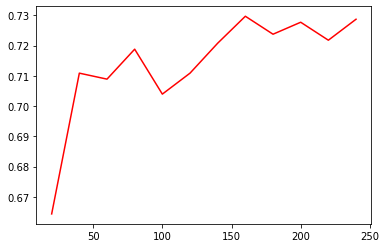

In [ ]:

score_lt = []
clf = DecisionTreeClassifier(max_depth=3,min_samples_split=160,min_samples_leaf=80)

for i in range(0,250,20):
    ada = AdaBoostClassifier(clf, n_estimators=i, learning_rate=0.5)
    score = cross_val_score(ada, x_train, y_train, cv=5).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+1))


x = np.arange(0,250,20)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
ada2 = AdaBoostClassifier(lr, n_estimators=50, learning_rate=0.05)#To remove
ada2.fit(x_train,y_train)#To remove

predict_results_train=ada2.predict(x_train)
print('Accuracy of train set: ',accuracy_score(predict_results_train, y_train))
predict_results=ada2.predict(x_test)
print('Accuracy of test set: ',accuracy_score(predict_results, y_test))
#print(cross_val_score(ada,x_train,y_train,cv=5).mean())

Accuracy of train set:  0.5138613861386139
Accuracy of test set:  0.5276497695852534


In [ ]:
svc=SVC(probability=True, kernel='linear')#computing time longer
ada3 = AdaBoostClassifier(svc, n_estimators=150, learning_rate=0.5)#To remove
ada3.fit(x_train,y_train)#To remove

predict_results_train=ada3.predict(x_train)
print('Accuracy of train set: ',accuracy_score(predict_results_train, y_train))
predict_results=ada3.predict(x_test)
print('Accuracy of test set: ',accuracy_score(predict_results, y_test))
#print(cross_val_score(ada,x_train,y_train,cv=5).mean())

GB

In [ ]:
params = {
     'n_estimators': np.arange(100,250,10),
     'learning_rate': [0.01, 0.05, 0.1,0.5],
 }
grid_cv = GridSearchCV(gb, param_grid= params, cv=5, n_jobs=-1)#max_depth=2
grid_cv.fit(x_train,y_train)
print("Best params:", grid_cv.best_params_)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(max_depth=2, n_estimators=100,learning_rate=0.05
                                ,min_samples_split=150,min_samples_leaf=60)# min_samples_split=150,min_samples_leaf=50 min_samples_leaf=60

gb.fit(x_train,y_train)

predict_results_train=gb.predict(x_train)
print('Accuracy of train set: ',accuracy_score(predict_results_train, y_train))
predict_results=gb.predict(x_test)
print('Accuracy of test set: ',accuracy_score(predict_results, y_test))
#print(cross_val_score(ada,x_train,y_train,cv=5).mean())

Accuracy of train set:  0.8465346534653465
Accuracy of test set:  0.7488479262672811


最大得分：nan 子树数量为：1


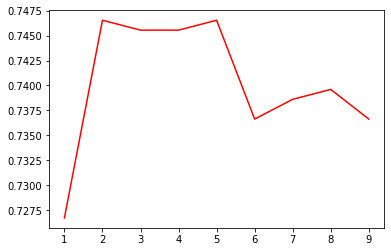

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
score_lt = []

for i in range(0,10,1):
    gb = GradientBoostingClassifier(max_depth=i, n_estimators=100,learning_rate=0.05)
    score = cross_val_score(gb, x_train, y_train, cv=5).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+1))


x = np.arange(0,10,1)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

xgboost

In [ ]:
from xgboost import XGBClassifier
### fit model for train data
xgb= XGBClassifier(learning_rate=0.03,
                   n_estimators=50,         
                   max_depth=7)#,min_child_weight=8,subsample=0.5

xgb.fit(x_train,y_train)
y_pred_train=xgb.predict(x_train)
y_pred = xgb.predict(x_test)
### model evaluate
accuracy_train = accuracy_score(y_train,y_pred_train)
accuracy_test = accuracy_score(y_test,y_pred)
#score_train=score(x_train,y_train)
#score_test=score(x_test,y_test)

print("accuarcy: ", accuracy_train)
print("accuarcy: ", accuracy_test)


accuarcy:  0.9792079207920792
accuarcy:  0.7534562211981567


In [ ]:
#xgb tuning
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth': [4,5,6], 'learning_rate': [0.01, 0.02,0.03, 0.05], 'n_estimators': [300,500,700,900] ,'min_child_weight': [0, 2, 5, 10]}
    


gsearch = GridSearchCV(xgb, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(x_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")

best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

最大得分：0.7554455445544555 子树数量为：51


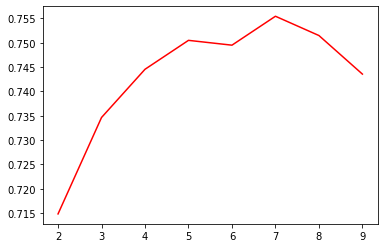

In [ ]:
from xgboost import XGBClassifier
score_lt = []

for i in range(2,10,1):
    xgb= XGBClassifier(n_estimators=50,         
                   max_depth=i)
    score = cross_val_score(xgb, x_train, y_train, cv=5).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+1))

x = np.arange(2,10,1)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

### 2. x_var

In [ ]:
# feature set 2
train_y
x_var

,price,retail_price,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,product_variation_inventory,shipping_option_price,countries_shipped_to,inventory_total,merchant_rating_count,tag_count,price_diff,product_color_black,product_color_blue,product_color_white,product_variation_size_id_m,product_variation_size_id_s,product_variation_size_id_verysmall,uses_ad_boosts_0,uses_ad_boosts_1,has_urgency_banner_0.0,has_urgency_banner_1.0,merchant_has_profile_picture_0,merchant_has_profile_picture_1,full_variation_inventory_0,full_variation_inventory_1,tag_summer_0,tag_summer_1,tag_women's fashion_0,tag_women's fashion_1,tag_casual_0,tag_casual_1,tag_plus size_0,tag_plus size_1,tag_sleeveless_0,tag_sleeveless_1,tag_dress_0,tag_dress_1,tag_shorts_0,tag_shorts_1,tag_tops_0,tag_tops_1,tag_sexy_0,tag_sexy_1,tag_beach_0,tag_beach_1,tag_sleeve_0,tag_sleeve_1,tag_short sleeves_0,tag_short sleeves_1,tag_print_0,tag_print_1,tag_shirt_0,tag_shirt_1,tag_tank_0,tag_tank_1,tag_necks_0,tag_necks_1,tag_v-neck_0,tag_v-neck_1,tag_printed_0,tag_printed_1
0,16.00,14.0,3.76,54.0,26.0,8.0,10.0,1.0,9.0,0.0,50.0,4.0,34.0,50.0,568.0,24.0,2.00,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,8.00,22.0,3.45,6135.0,2269.0,1027.0,1118.0,644.0,1077.0,0.0,50.0,2.0,41.0,50.0,17752.0,15.0,-14.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,8.00,43.0,3.57,14.0,5.0,4.0,2.0,0.0,3.0,0.0,1.0,3.0,36.0,50.0,295.0,19.0,-35.00,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,8.00,8.0,4.03,579.0,295.0,119.0,87.0,42.0,36.0,0.0,50.0,2.0,41.0,50.0,23832.0,18.0,0.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,2.72,3.0,3.10,20.0,6.0,4.0,2.0,2.0,6.0,0.0,1.0,1.0,35.0,50.0,14482.0,13.0,-0.28,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,6.00,9.0,4.08,1367.0,722.0,293.0,185.0,77.0,90.0,0.0,50.0,2.0,41.0,50.0,5316.0,24.0,-3.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1440,2.00,56.0,3.07,28.0,11.0,3.0,1.0,3.0,10.0,0.0,2.0,1.0,26.0,50.0,4435.0,18.0,-54.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1441,5.00,19.0,3.71,59.0,24.0,15.0,8.0,3.0,9.0,0.0,15.0,2.0,11.0,50.0,210.0,12.0,-14.00,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1442,13.00,11.0,2.50,2.0,0.0,1.0,0.0,0.0,1.0,0.0,36.0,3.0,29.0,50.0,31.0,21.0,2.00,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
